## CPE-695 Forest Fire Prediction and Analysis

### Discription of Dataset

X - x-axis spatial coordinate within the Montesinho park map: 1 to 9

Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9

month - month of the year: 'jan' to 'dec'

day - day of the week: 'mon' to 'sun'

FFMC - FFMC index from the FWI system: 18.7 to 96.20

DMC - DMC index from the FWI system: 1.1 to 291.3

DC - DC index from the FWI system: 7.9 to 860.6

ISI - ISI index from the FWI system: 0.0 to 56.10

temp - temperature in Celsius degrees: 2.2 to 33.30

RH - relative humidity in %: 15.0 to 100

wind - wind speed in km/h: 0.40 to 9.40

rain - outside rain in mm/m2 : 0.0 to 6.4

area - the burned area of the forest (in ha): 0.00 to 1090.84

(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

The Fine Fuel Moisture Code (FFMC) represents fuel moisture of forest litter fuels under the shade of a forest 
canopy. It is intended to represent moisture conditions for shaded litter fuels, the equivalent of 16-hour time lag. 
It ranges from 0-101. Subtracting the FFMC value from 100 can provide an estimate for the equivalent 
(approximately 10h) fuel moisture content, most accurate when FFMC values are roughly above 80

Fuel moisture is a measure of the amount of water in a fuel (vegetation) available to a fire, and is expressed as a percent of the dry weight of that specific fuel. For example, if a fuel were totally dry, the fuel moisture content would be zero percent.

The Drought Code (DC), much like the Keetch-Byrum Drought Index, represents drying deep into the soil. It approximates moisture conditions for the equivalent of 53-day (1272 hour) time-lag fuels. It is unitless, with a maximum value of 1000. Extreme drought conditions have produced DC values near 800.

The Initial Spread Index (ISI) is analogous to the NFDRS Spread Component (SC). It integrates fuel moisture for fine dead fuels and surface windspeed to estimate a spread potential. ISI is a key input for fire behavior predictions in the FBP system. It is unitless and open ended.

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score

### Data Visualization

In [2]:
df = pd.read_csv("forestfires.csv")
df

X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
df.describe()

X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655818  
min      2.200000   15.000000    0.400000    0.000000     0.000000  
25%     15.500000   33.000000    2.700000    0.000000     0.000000  
50%     19.300000   42.000000    4.000000    0.000000     0.520000  
75%     22.800000   53.000000    4.900000    0.000000     6.570000  
max     33.300000  100.000000    9.400000    6.400000  1090.840000

C:\Users\misra\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


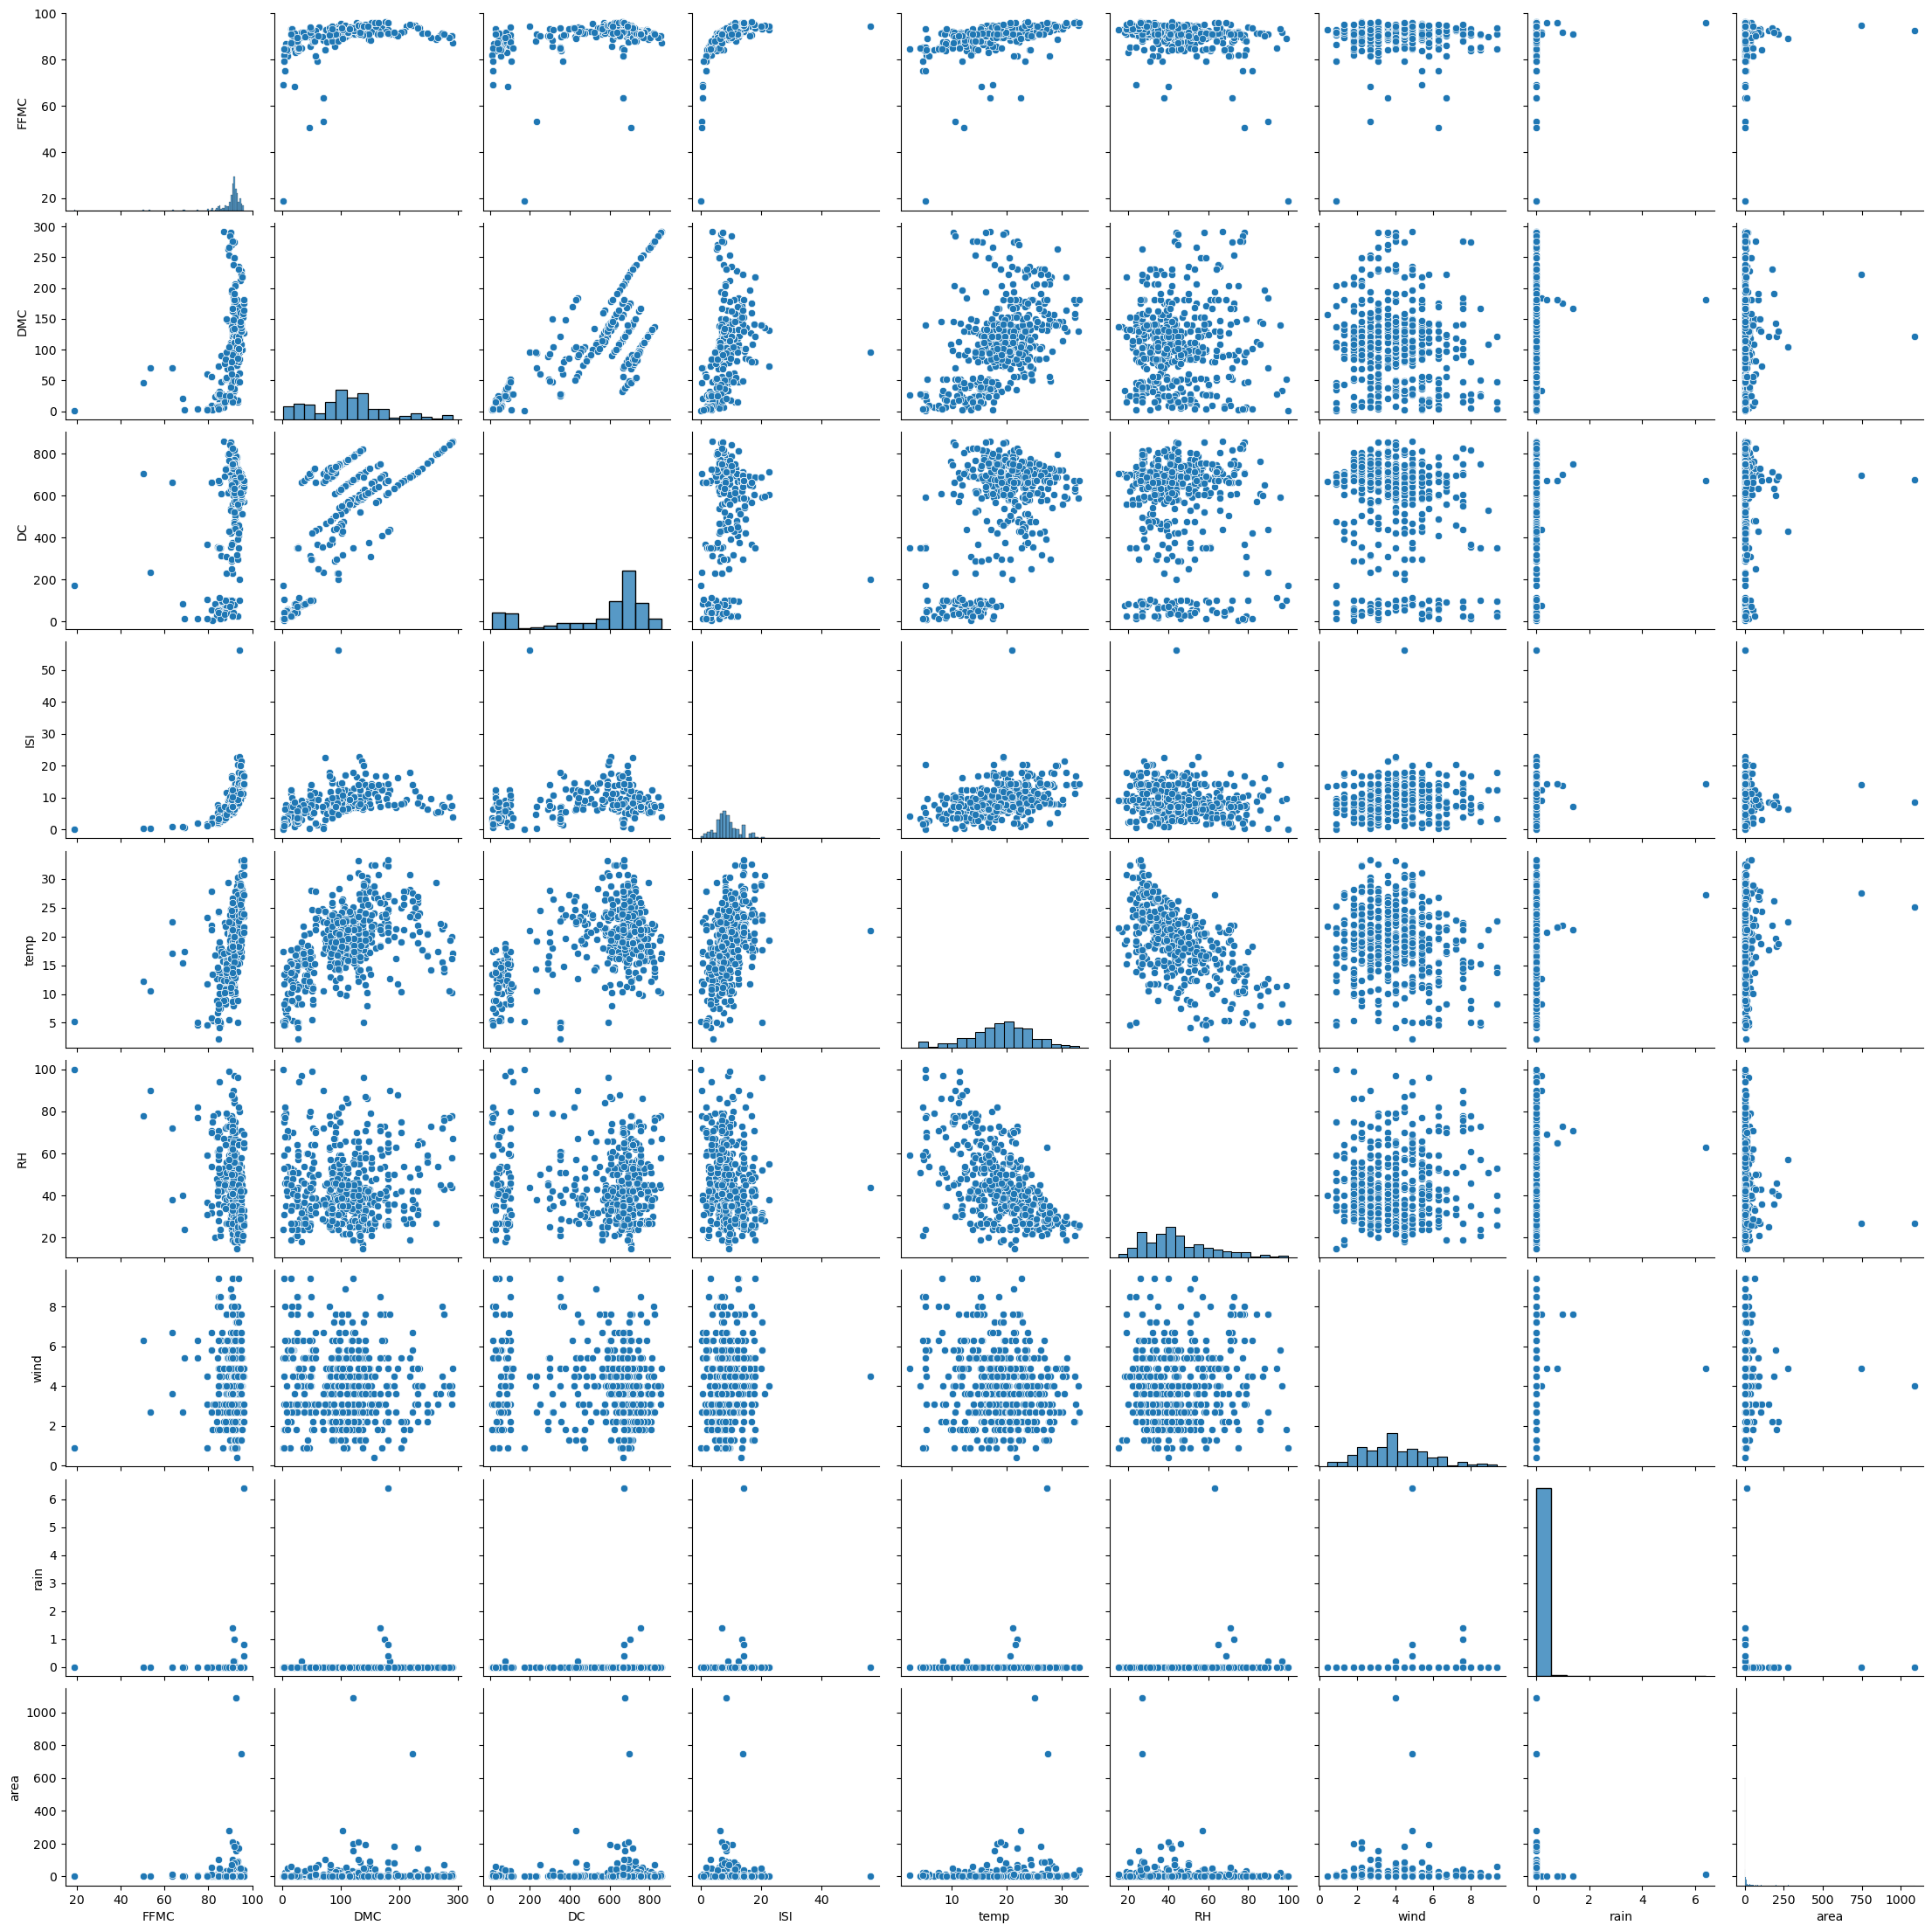

In [5]:
sns.pairplot(df, vars=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", "area"])
plt.show()

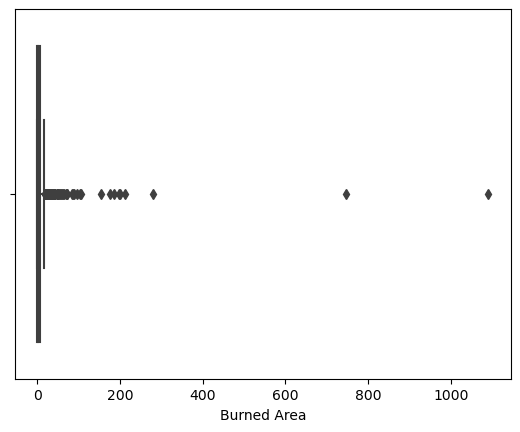

In [6]:
sns.boxplot(x=df["area"])
plt.xlabel("Burned Area")
plt.show()

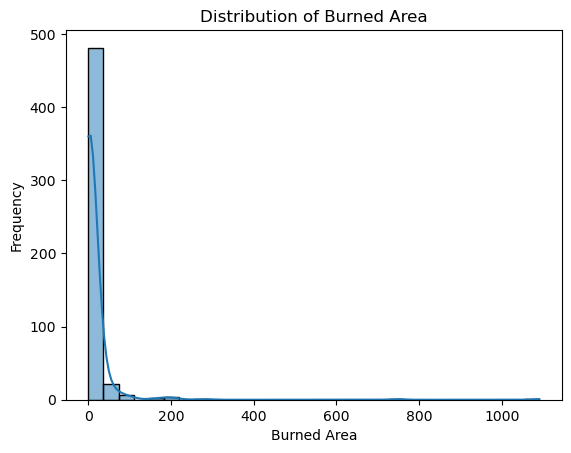

In [7]:
sns.histplot(df["area"], bins=30, kde=True)
plt.xlabel("Burned Area")
plt.ylabel("Frequency")
plt.title("Distribution of Burned Area")
plt.show()

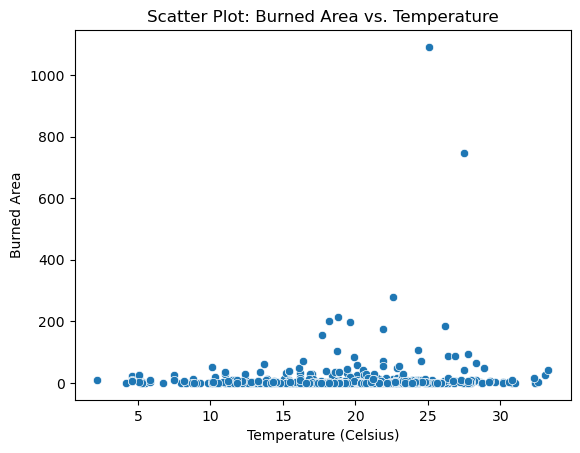

In [8]:
sns.scatterplot(x="temp", y="area", data=df)
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Burned Area")
plt.title("Scatter Plot: Burned Area vs. Temperature")
plt.show()

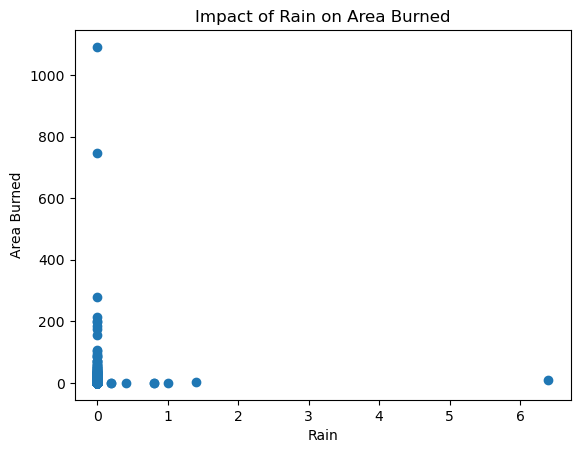

In [9]:
plt.scatter(df['rain'], df['area'])
plt.title('Impact of Rain on Area Burned')
plt.xlabel('Rain')
plt.ylabel('Area Burned')
plt.show()

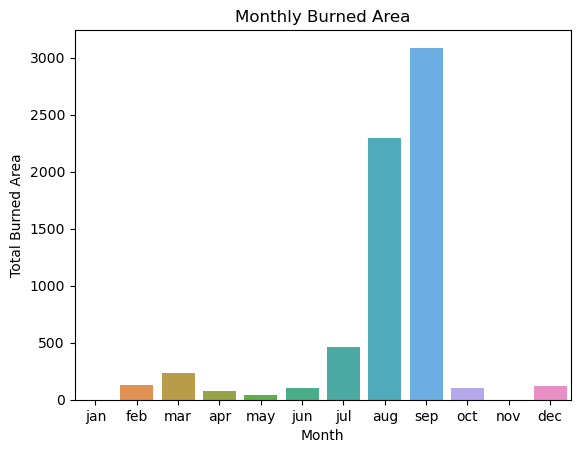

In [10]:
data_monthly = df.groupby("month")["area"].sum().reset_index()
sns.barplot(x="month", y="area", data=data_monthly, order=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
plt.xlabel("Month")
plt.ylabel("Total Burned Area")
plt.title("Monthly Burned Area")
plt.show()

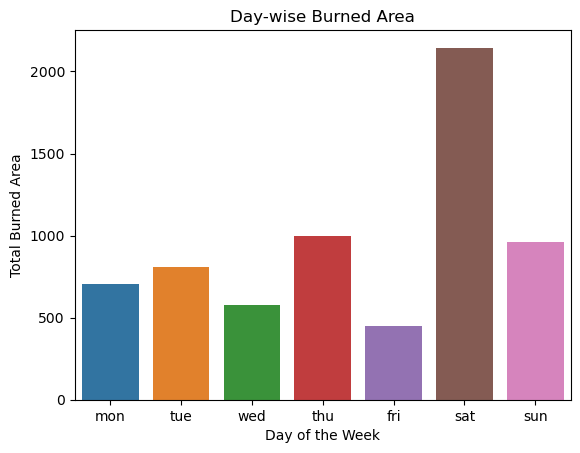

In [11]:
data_daily = df.groupby("day")["area"].sum().reset_index()
sns.barplot(x="day", y="area", data=data_daily, order=["mon", "tue", "wed", "thu", "fri", "sat", "sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Total Burned Area")
plt.title("Day-wise Burned Area")
plt.show()

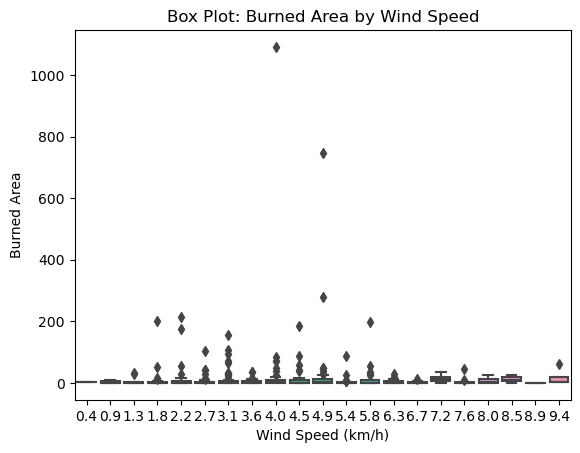

In [12]:
sns.boxplot(x="wind", y="area", data=df)
plt.xlabel("Wind Speed (km/h)")
plt.ylabel("Burned Area")
plt.title("Box Plot: Burned Area by Wind Speed")
plt.show()

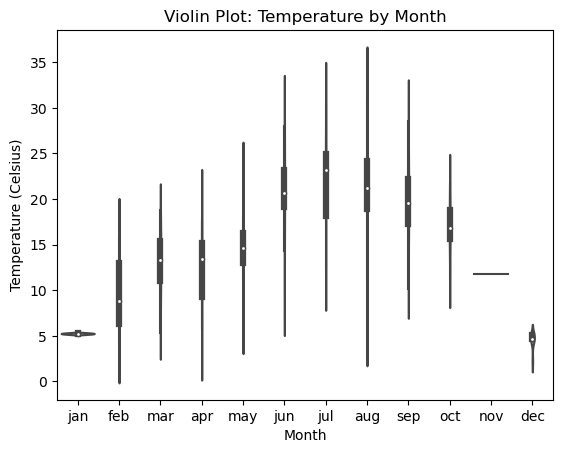

In [13]:
sns.violinplot(x="month", y="temp", data=df, order=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
plt.xlabel("Month")
plt.ylabel("Temperature (Celsius)")
plt.title("Violin Plot: Temperature by Month")
plt.show()

C:\Users\misra\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


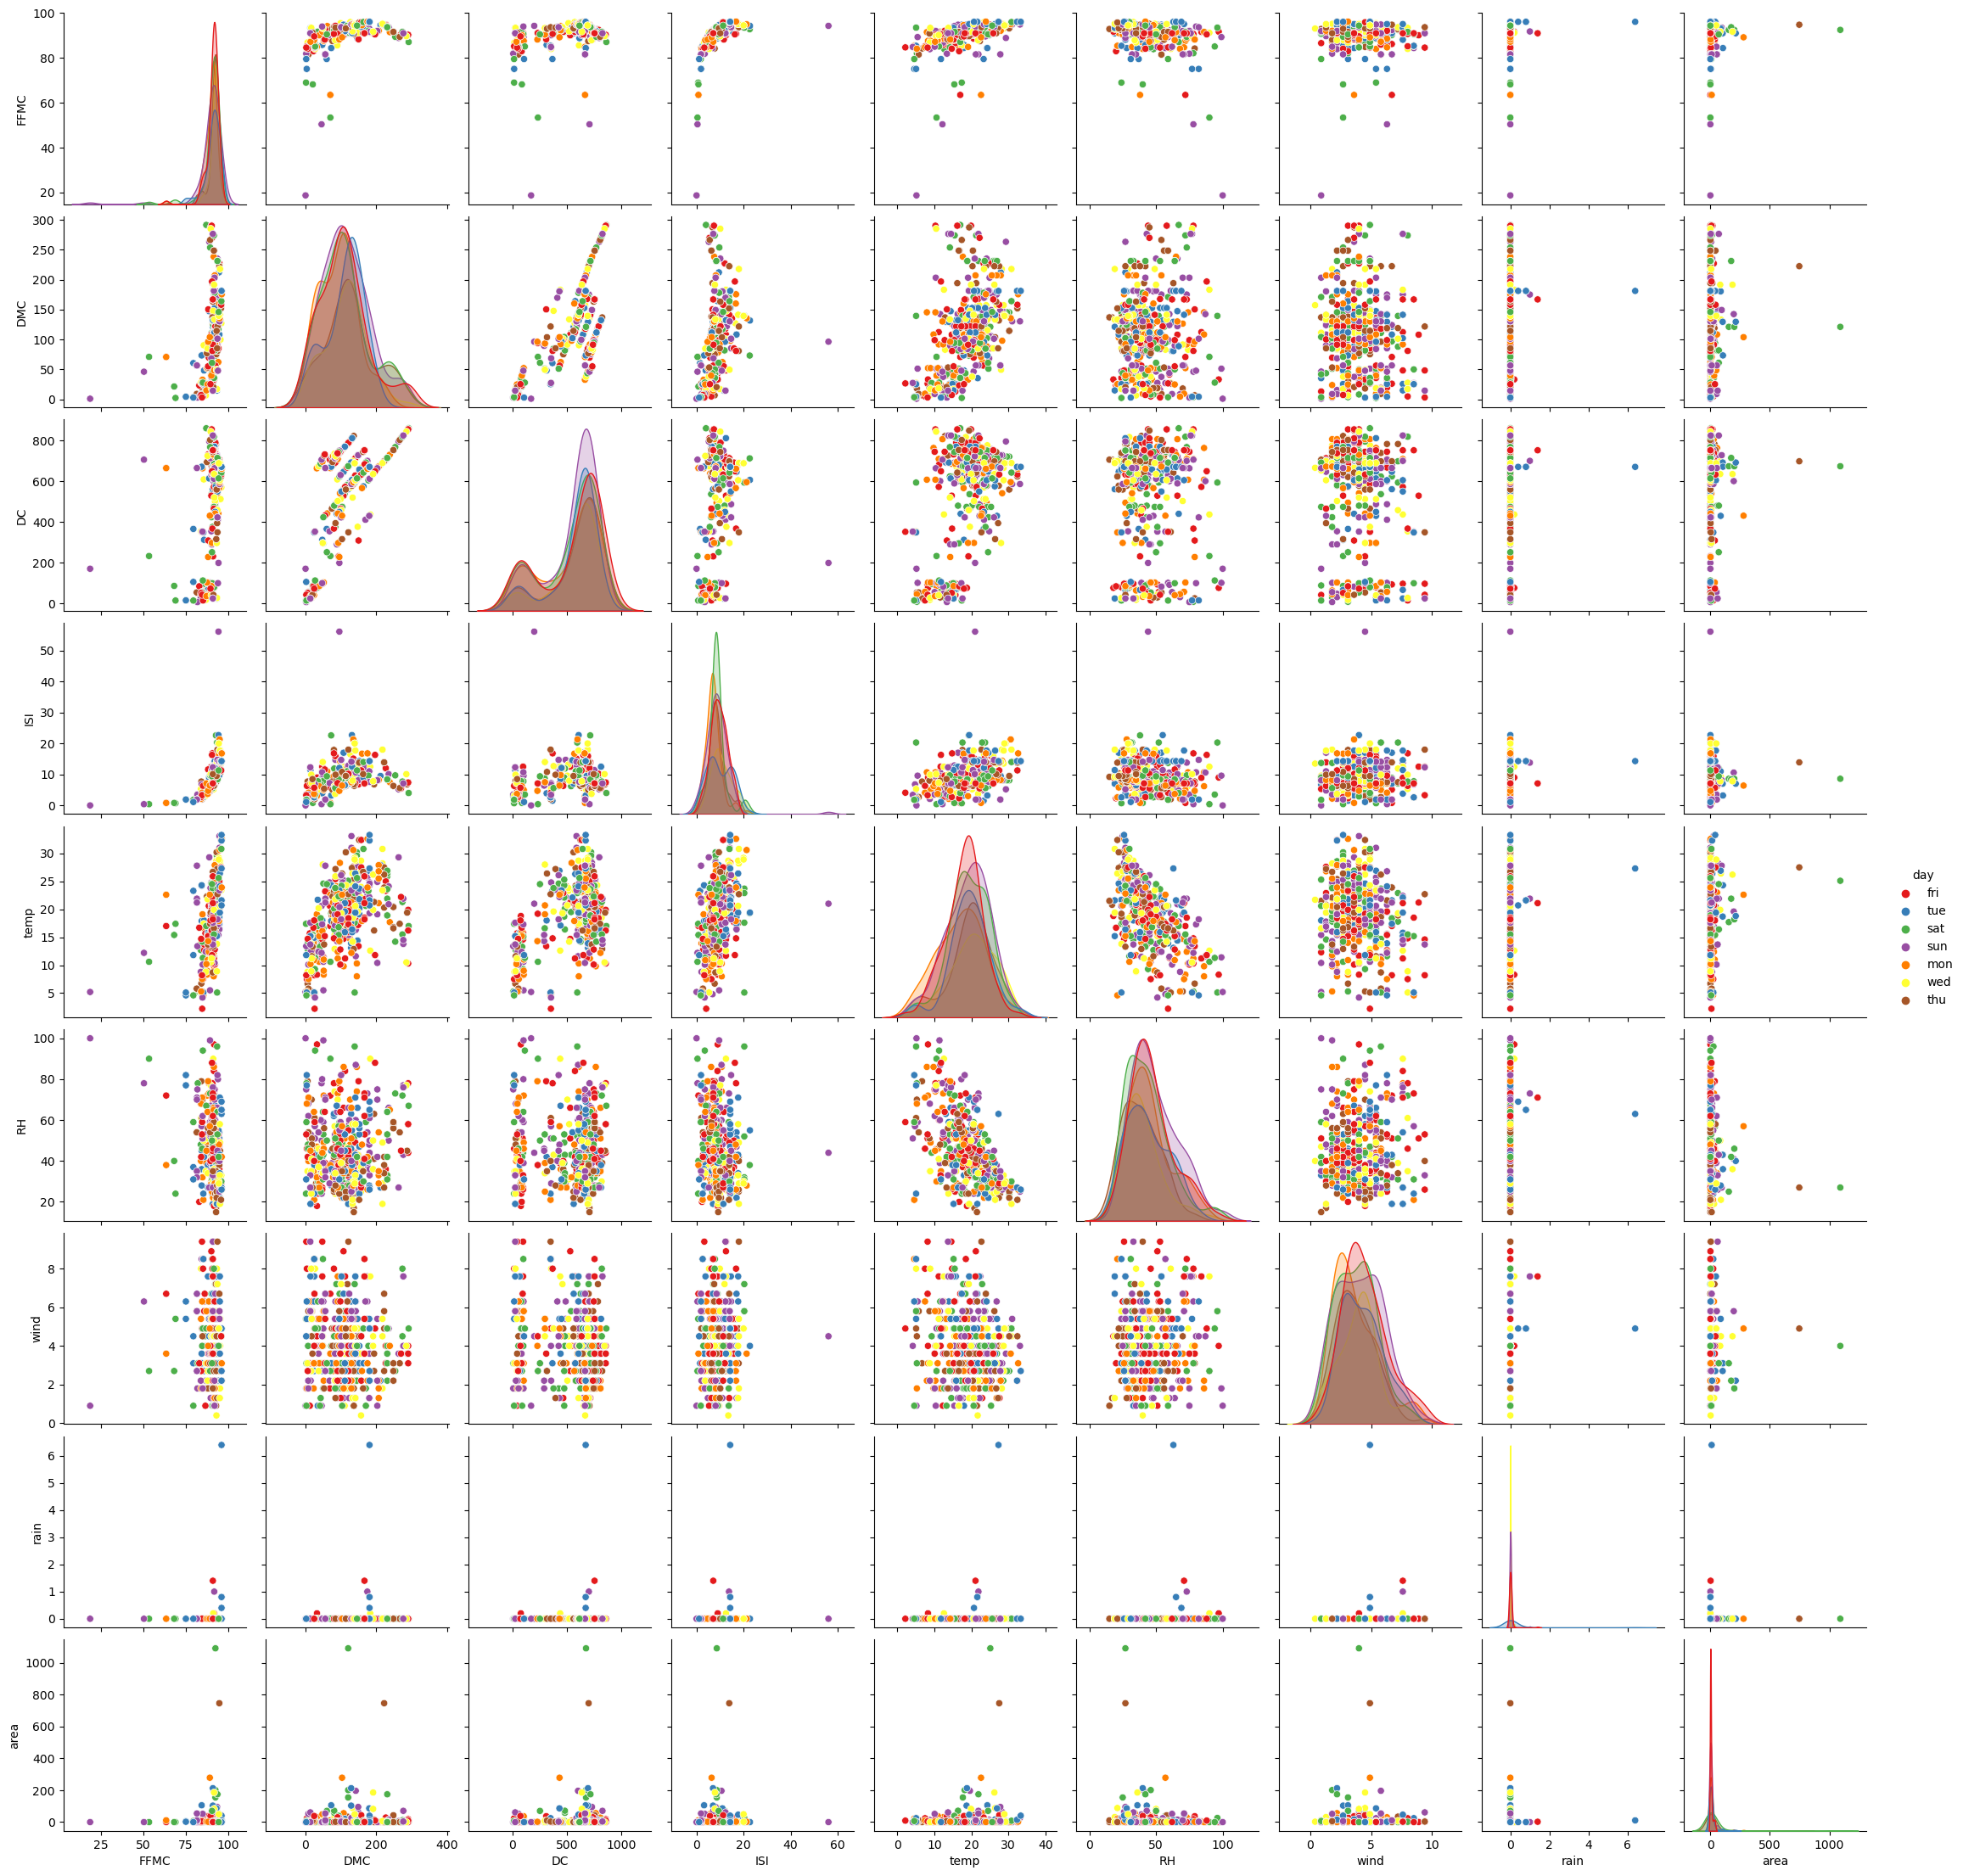

In [14]:
sns.pairplot(df, vars=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", "area"], hue="day", palette="Set1")
plt.show()

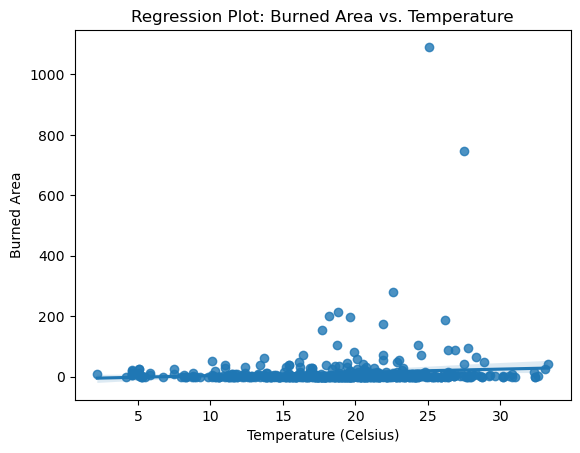

In [15]:
sns.regplot(x="temp", y="area", data=df)
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Burned Area")
plt.title("Regression Plot: Burned Area vs. Temperature")
plt.show()

### Data Preperation

In [16]:
def find_season(month):
    if month in ['sep','oct','nov']:
        return 'fall'
    elif month in ['jun','jul','aug']:
        return 'summer'
    elif month in ['mar','apr','may']:
        return 'spring'
    else:
        return 'winter'

In [17]:
def at_risk(area):
    if area >5:
        return 1
    else:
        return 0

In [18]:
mean=df['area'].mean()
std=df['area'].std()
print('Mean is:',mean)
print('STD is:',std)

Mean is: 12.847292069632493
STD is: 63.65581846794077


In [19]:
season_dict={'month':df['month'],
           'day':df['day'],
           'season':df['month'].apply(find_season)}
season_df=pd.DataFrame(season_dict)
season_columns=['month','day','season']

In [20]:
season_df

month  day  season
0     mar  fri  spring
1     oct  tue    fall
2     oct  sat    fall
3     mar  fri  spring
4     mar  sun  spring
..    ...  ...     ...
512   aug  sun  summer
513   aug  sun  summer
514   aug  sun  summer
515   aug  sat  summer
516   nov  tue    fall

[517 rows x 3 columns]

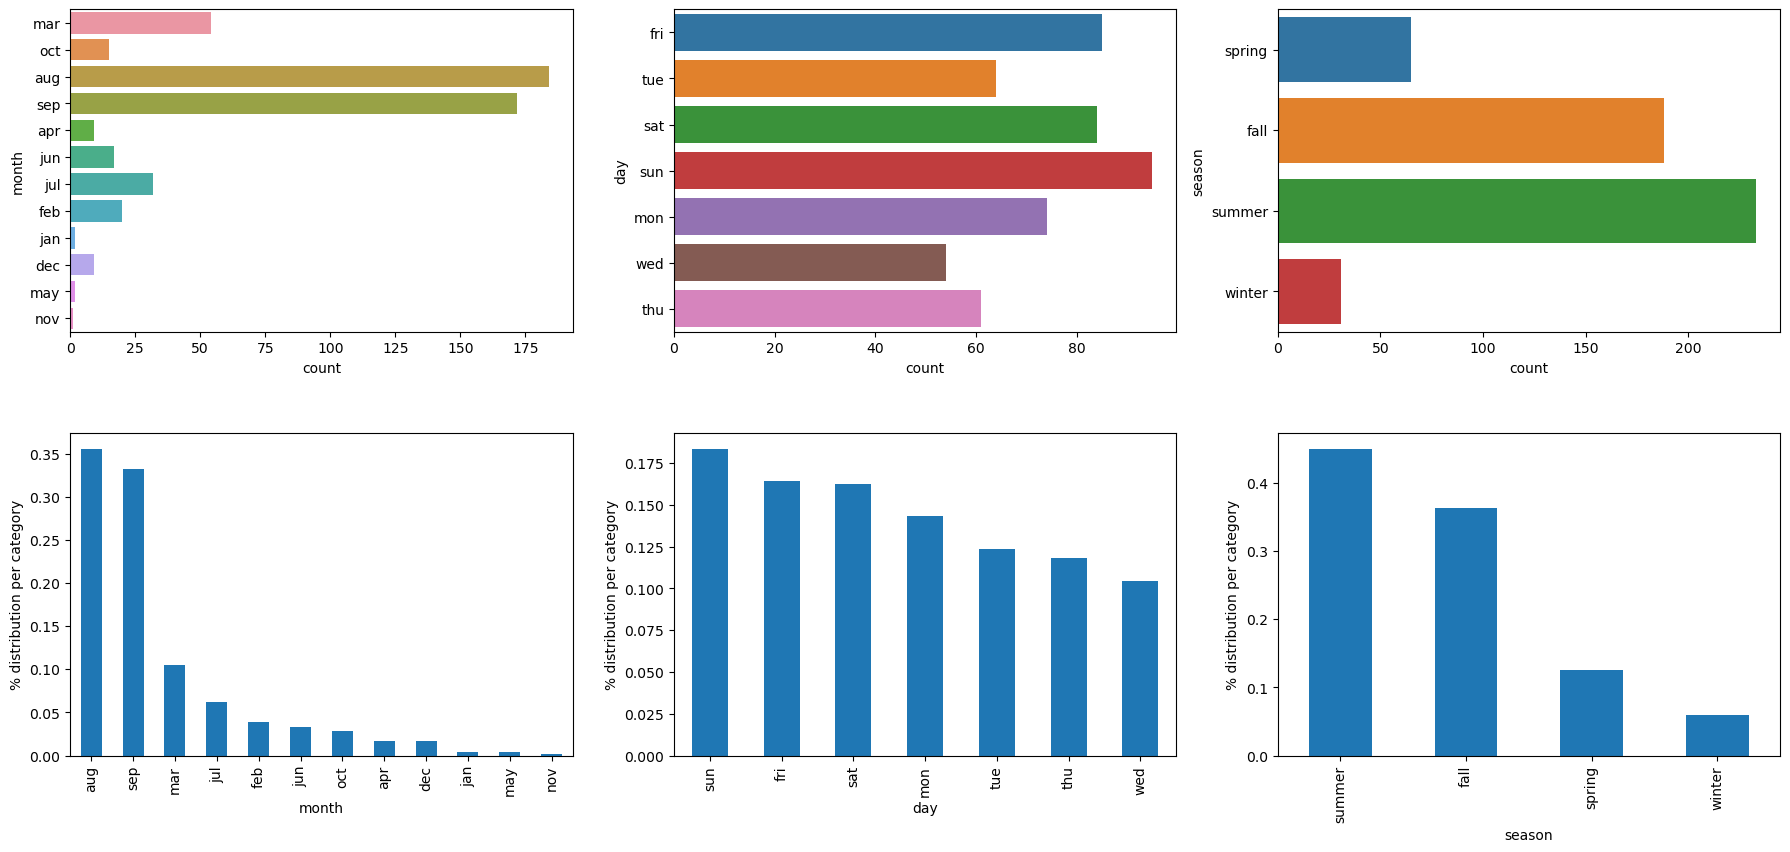

In [21]:
plt.figure(figsize=(18,12))
for i,j in enumerate(season_columns,1):
    plt.subplot(3,3,i)
    sns.countplot(data=season_df,y=j)
    plt.subplot(3,3,i+3)
    season_df[j].value_counts(normalize=True).plot.bar()
    plt.ylabel('% distribution per category')
    plt.xlabel(j)
plt.tight_layout()
plt.show()  

In [22]:
burnt_area=df['area']

pertile=[25, 50, 75, 90, 95]
pertiles_values=np.percentile(burnt_area,pertile)

for i,j in enumerate(pertile):
    print(f"{j}th percentile: {pertiles_values[i]}")

colors=['red','green','blue','purple','orange']

25th percentile: 0.0
50th percentile: 0.52
75th percentile: 6.57
90th percentile: 25.262000000000043
95th percentile: 48.713999999999984


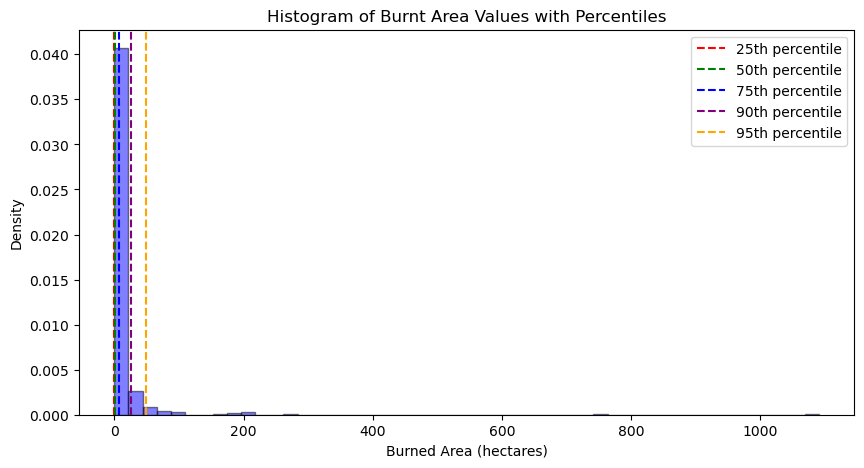

In [23]:
plt.figure(figsize=(10,5))
plt.hist(burnt_area, bins=50, color='blue', edgecolor='black', alpha=0.5, density=True)
for p, value, color in zip(pertile, pertiles_values, colors):
    plt.axvline(value, color=color, linestyle='--', label=f'{p}th percentile')
plt.xlabel('Burned Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Burnt Area Values with Percentiles')
plt.show()

In [24]:
plt.figure(figsize=(10, 5))
sns.kdeplot(burnt_area, fill=False, color='gray', alpha=0.5)

for p, value, color in zip(pertile, pertiles_values, colors):
    plt.axvline(value, color=color, linestyle='--', label=f'{p}th percentile')
    sns.kdeplot(burnt_area, fill=True, clip=(value, np.inf), color=color, alpha=0.2)

plt.xlabel('Burnt Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.title('Density Plot of Burnt Area Values with Highlighted Areas')
plt.show()

In [25]:
df['high risk']=df['area'].apply(at_risk)
df['season']=df['month'].apply(find_season)


df2=df[['high risk','area','FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
correlation_matrix=df2.corr()

In [26]:
import plotly.subplots as sp


fig=sp.make_subplots(rows=1,cols=1)
heatmap=go.Heatmap(z=correlation_matrix,x=correlation_matrix.columns,y=correlation_matrix.columns,colorscale='RdBu_r', zmin=-1, zmax=1)
fig.add_trace(heatmap)

for i, row in enumerate(correlation_matrix.index):
    for j, col in enumerate(correlation_matrix.columns):
        fig.add_annotation(go.layout.Annotation(text=f"{correlation_matrix.iloc[i, j]:.2f}",x=col,y=row,showarrow=False,font=dict(size=12)))

fig.update_layout(title='Correlation Matrix Heatmap',xaxis_title='Variables',yaxis_title='Variables')
fig.show()

In [27]:
df2.corr()['high risk'].sort_values(ascending=False)

high risk    1.000000
area         0.297696
wind         0.056899
rain         0.045013
DC           0.023488
DMC          0.022469
FFMC         0.005749
temp        -0.003714
ISI         -0.026401
RH          -0.041625
Name: high risk, dtype: float64

In [28]:
def standardize(df, lst):
    for var in lst:
        df[var+'_sd'] = (df[var] - np.mean(df[var])) / np.std(df[var])

In [29]:

area_zero_count = (df['area'] == 0).sum()
area_more_than_zero_count = (df['area'] > 0).sum()


In [30]:
fig1 = go.Figure(go.Bar(x=['Area = 0', 'Area > 0'], y=[area_zero_count, area_more_than_zero_count], marker_color=['blue', 'orange']))

In [31]:
fig1.update_layout(title='Number of Instances with Area Equal to 0 vs. More Than 0', xaxis_title='Area Groups', yaxis_title='Count')


In [32]:
# Count the instances for the second bar graph (5 or greater vs. less than 5)
area_less_than_ten_count = (df['area'] < 10).sum()
area_ten_or_greater_count = (df['area'] >= 10).sum()

In [33]:
fig2 = go.Figure(go.Bar(x=['Area < 10', 'Area >= 10'], y=[area_less_than_ten_count, area_ten_or_greater_count], marker_color=['blue', 'orange']))
fig2.update_layout(title='Number of Instances with Area Less Than 10 vs. 10 or Greater', xaxis_title='Area Groups', yaxis_title='Count')

fig1.show()
fig2.show()

In [34]:
one_hot_encoded = pd.get_dummies(df['season'], prefix='season')
forestfires_encoded = pd.concat([df, one_hot_encoded], axis=1)
forestfires_encoded.drop('season', axis=1, inplace=True)

standardize(forestfires_encoded, ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'])
forestfires_encoded

X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  ...  season_winter  \
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51  ...          False   
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33  ...          False   
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33  ...          False   
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97  ...          False   
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99  ...          False   
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..  ...            ...   
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32  ...          False   
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71  ...          False   
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70  ...          False   
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42  ...          False   
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31  ...          False   

      FFMC_sd    DMC_sd     DC_sd    ISI_sd   temp_sd     RH_sd   wind_sd  \
0   -0.805959 -1.323326 -1.830477 -0.860946 -1.842640  0.411724  1.498614   
1   -0.008102 -1.179541  0.488891 -0.509688 -0.153278 -0.692456 -1.741756   
2   -0.008102 -1.049822  0.560715 -0.509688 -0.739383 -0.692456 -1.518282   
3    0.191362 -1.212361 -1.898266 -0.004756 -1.825402  3.233519 -0.009834   
4   -0.243833 -0.931043 -1.798600  0.126966 -1.291012  3.356206 -1.238940   
..        ...       ...       ...       ...       ...       ...       ...   
512 -1.640083 -0.846648  0.474768 -1.563460  1.536084 -0.753800 -0.736124   
513 -1.640083 -0.846648  0.474768 -1.563460  0.519019  1.638592  0.995798   
514 -1.640083 -0.846648  0.474768 -1.563460  0.398350  1.577248  1.498614   
515  0.680957  0.549003  0.269382  0.500176  1.156839 -0.140366 -0.009834   
516 -2.020879 -1.685913 -1.780442 -1.739089 -1.222058 -0.815143  0.269509   

      rain_sd   area_sd  
0   -0.073268 -0.202020  
1   -0.073268 -0.202020  
2   -0.073268 -0.202020  
3    0.603155 -0.202020  
4   -0.073268 -0.202020  
..        ...       ...  
512 -0.073268 -0.100753  
513 -0.073268  0.651674  
514 -0.073268 -0.026532  
515 -0.073268 -0.202020  
516 -0.073268 -0.202020  

[517 rows x 27 columns]

In [35]:
all_features = ['high risk', 'area', 'FFMC_sd', 'DMC_sd', 'DC_sd', 'ISI_sd', 'temp_sd', 'RH_sd', 'wind_sd', 'rain_sd']
correlation_matrix_all = forestfires_encoded[all_features].corr()

fig_all = ff.create_annotated_heatmap(
    z=correlation_matrix_all.values,
    x=list(correlation_matrix_all.columns),
    y=list(correlation_matrix_all.index),
    colorscale='RdBu_r',
    annotation_text=correlation_matrix_all.round(2).values,
    showscale=True
)

fig_all.update_layout(
    title='Correlation Heatmap of All Forest Fires Features',
    xaxis=dict(title='Features', side='bottom'),
    yaxis=dict(title='Features'),
)

fig_all.show()

In [36]:
forestfires_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   month          517 non-null    object 
 3   day            517 non-null    object 
 4   FFMC           517 non-null    float64
 5   DMC            517 non-null    float64
 6   DC             517 non-null    float64
 7   ISI            517 non-null    float64
 8   temp           517 non-null    float64
 9   RH             517 non-null    int64  
 10  wind           517 non-null    float64
 11  rain           517 non-null    float64
 12  area           517 non-null    float64
 13  high risk      517 non-null    int64  
 14  season_fall    517 non-null    bool   
 15  season_spring  517 non-null    bool   
 16  season_summer  517 non-null    bool   
 17  season_winter  517 non-null    bool   
 18  FFMC_sd   

In [37]:
forestfires_encoded = pd.get_dummies(df,columns=['day','month','season'],drop_first=True)

### ML #1 Neural Network

In [38]:
bool_columns = ['day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed',
                'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
                'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
                'month_sep', 'season_spring', 'season_summer', 'season_winter']

forestfires_encoded[bool_columns] = forestfires_encoded[bool_columns].astype(int)

X = forestfires_encoded.drop(['high risk'], axis=1)  # Features
y = forestfires_encoded['high risk']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(8, input_dim=X_train.shape[1], activation='relu'),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Test accuracy: {accuracy}')

from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred_binary))

Epoch 1/50
413/413 [==============================] - 1s 652us/step - loss: 0.9494 - accuracy: 0.3947
Epoch 2/50
413/413 [==============================] - 0s 609us/step - loss: 0.6705 - accuracy: 0.6707
Epoch 3/50
413/413 [==============================] - 0s 583us/step - loss: 0.5865 - accuracy: 0.7458
Epoch 4/50
413/413 [==============================] - 0s 586us/step - loss: 0.5464 - accuracy: 0.7627
Epoch 5/50
413/413 [==============================] - 0s 581us/step - loss: 0.5205 - accuracy: 0.7748
Epoch 6/50
413/413 [==============================] - 0s 587us/step - loss: 0.4959 - accuracy: 0.7966
Epoch 7/50
413/413 [==============================] - 0s 581us/step - loss: 0.4702 - accuracy: 0.7966
Epoch 8/50
413/413 [==============================] - 0s 573us/step - loss: 0.4442 - accuracy: 0.8087
Epoch 9/50
413/413 [==============================] - 0s 575us/step - loss: 0.4195 - accuracy: 0.8208
Epoch 10/50
413/413 [==============================] - 0s 588us/step - loss: 0.395

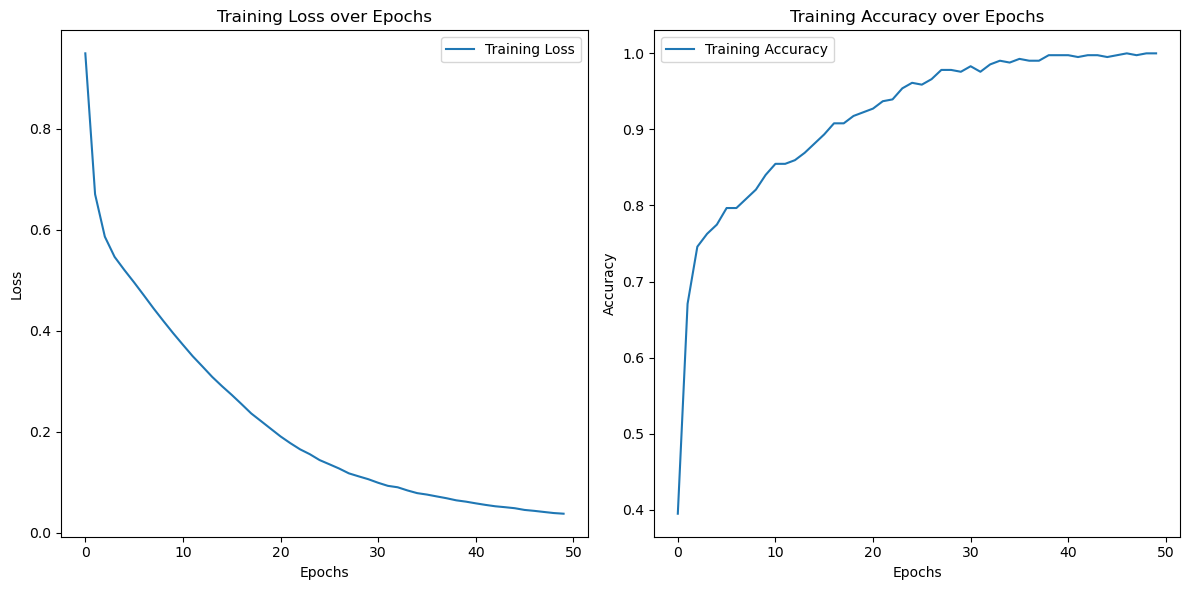

In [39]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### ML #2 K-Nearest Neighbour

Best Accuracy: 0.8461538461538461 with n_neighbors=2


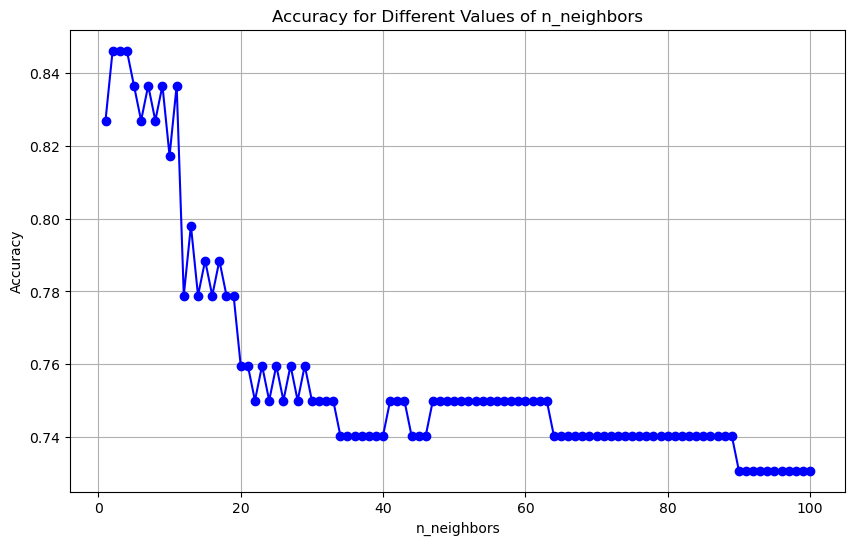

Best Accuracy: 0.8461538461538461 with n_neighbors=2


In [40]:
X = forestfires_encoded.drop('high risk', axis=1).values  
y = forestfires_encoded['high risk'].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

accuracy_values = []
best_accuracy = 0
best_n_neighbors = 0

for n_neighbors in range(1, 101):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_neighbors = n_neighbors

print(f'Best Accuracy: {best_accuracy} with n_neighbors={best_n_neighbors}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(f'Best Accuracy: {best_accuracy} with n_neighbors={best_n_neighbors}')

### ML #3 Random Forest

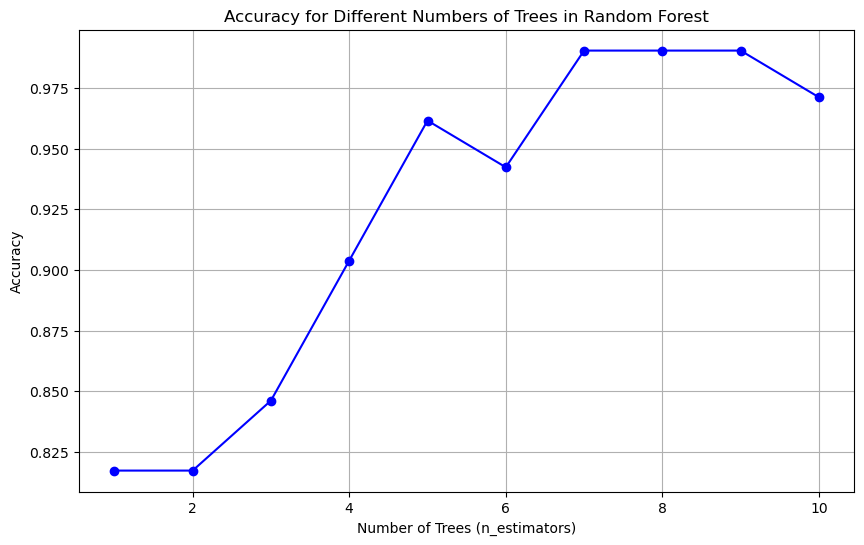

Classification Report - Random Forest:
Best Accuracy: 0.9903846153846154 with n_estimators=7
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        74
           1       1.00      0.90      0.95        30

    accuracy                           0.97       104
   macro avg       0.98      0.95      0.96       104
weighted avg       0.97      0.97      0.97       104

Confusion Matrix:
[[74  0]
 [ 3 27]]


In [41]:
X = forestfires_encoded.drop('high risk', axis=1).values 
y = forestfires_encoded['high risk'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

accuracy_values = []

best_accuracy = 0
best_n_estimators = 0

for n_estimators in range(1, 11):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_estimators = n_estimators

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy for Different Numbers of Trees in Random Forest')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print('Classification Report - Random Forest:')
print(f'Best Accuracy: {best_accuracy} with n_estimators={best_n_estimators}')

print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

### Comparison #1 Plotting 'Receiving Operating Characteristic' Curve

In [42]:
X = forestfires_encoded.drop('high risk', axis=1).values
y = forestfires_encoded['high risk'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_one_hot = label_binarize(y_train, classes=[0, 1])
y_test_one_hot = label_binarize(y_test, classes=[0, 1])

# Neural Network
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train_one_hot)
y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
y_score_mlp = mlp.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_one_hot, y_score_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
y_score_knn = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
y_score_rf = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print(f'Neural Network Accuracy: {accuracy_mlp:.2f}')
print(f'KNN Accuracy: {accuracy_knn:.2f}')
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')

plt.figure(figsize=(8, 8))

plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'Neural Network (AUC = {roc_auc_mlp:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

C:\Users\misra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\misra\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Neural Network Accuracy: 0.97
KNN Accuracy: 0.81
Random Forest Accuracy: 1.00


### Comparison #2 Confution Matrix

In [43]:
def print_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix - {title}:")
    print(cm)


def print_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred)
    print(f"Classification Report - {title}:")
    print(report)

print_confusion_matrix(y_test, y_pred_mlp, 'Neural Network')
print_classification_report(y_test, y_pred_mlp, 'Neural Network')

print_confusion_matrix(y_test, y_pred_knn, 'KNN')
print_classification_report(y_test, y_pred_knn, 'KNN')

print_confusion_matrix(y_test, y_pred_rf, 'Random Forest')
print_classification_report(y_test, y_pred_rf, 'Random Forest')

Confusion Matrix - Neural Network:
[[111   0]
 [  4  41]]
Classification Report - Neural Network:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       111
           1       1.00      0.91      0.95        45

    accuracy                           0.97       156
   macro avg       0.98      0.96      0.97       156
weighted avg       0.98      0.97      0.97       156

Confusion Matrix - KNN:
[[107   4]
 [ 26  19]]
Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.80      0.96      0.88       111
           1       0.83      0.42      0.56        45

    accuracy                           0.81       156
   macro avg       0.82      0.69      0.72       156
weighted avg       0.81      0.81      0.79       156

Confusion Matrix - Random Forest:
[[111   0]
 [  0  45]]
Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       1.